<a href="https://colab.research.google.com/github/lesterbogran/comparativa-deteccion-personas/blob/main/tfm_inferencias_comparativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descarga y preparación del dataset

In [ ]:
# descarga del dataset esto puede tomar unos 15-20 minutos
!wget  https://data.4tu.nl/ndownloader/files/24070793

--2022-02-09 02:44:23--  https://data.4tu.nl/ndownloader/files/24070793
Resolving data.4tu.nl (data.4tu.nl)... 131.180.141.15
Connecting to data.4tu.nl (data.4tu.nl)|131.180.141.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘24070793’

24070793                [<=>                 ]   9.98G  11.2MB/s    in 16m 52s 

2022-02-09 03:01:16 (10.1 MB/s) - ‘24070793’ saved [10713417760]



In [ ]:
# descompresion del dataset esto puede tomar unos 4-6 minutos
!unzip -qq ./24070793 
!ls

24070793  sample_data  wisenet_dataset


In [ ]:
import cv2
import os
import json
import pandas as pd
# Para ordenar aleatoriamente los datos
import random

In [ ]:
# distribución original del dataset wisenet
sets = 11
detection_dir ='wisenet_dataset/manual_annotations/people_detection/set_'
video_dir = 'wisenet_dataset/video_sets/set_'
image_dataset_dir = 'wisenet_img_dataset'

In [ ]:
# crear el directorio donde se guardaran las imágenes
!mkdir wisenet_img_dataset

In [ ]:
# creacion de un unico archivo json para guardar la meta información
for i in range(1, sets+1):
  files = os.listdir(detection_dir+str(i))
  for f in files:
    f_json =  detection_dir+str(i)+"/"+f
    with open(f_json, "r") as ans:
      an = json.load(ans)
      resolution = an["resolution"][0]

In [ ]:
# función para generar las imágenes a partir de un video
def generate_images(base_dir, tags, video, set_id, video_id):
  f_json = open(tags)
  annotations = json.load(f_json)
  f_json.close()
  frames = annotations["frames"]
  resolution = annotations["resolution"][0]
  vidCap = cv2.VideoCapture(video)  
  f = -1
  list_frames =[]
  #success,image = vidCap.read()
  for frame in frames:
    fm = int(frame['frameNumber'])

    while f < fm: 
      success,image = vidCap.read()
      f +=1
    img_name = "image_video%d_%d_%d.jpg" %  (set_id, video_id, fm)
    cv2.imwrite("%s/%s" % (base_dir, img_name), image)

    dict_an = {}
    dict_an['image'] =  img_name
    dict_an['people'] = [(x['xywh'][0], x['xywh'][1], 
                          x['xywh'][0] + x['xywh'][2], x['xywh'][1] + x['xywh'][3])    
                         for x in frame['detections'] if x['class'] == 'person']
    dict_an['total'] = len(dict_an['people'])
    dict_an['resolution'] = resolution
    list_frames.append(dict_an)

  return list_frames

In [ ]:
# procesamiento de los videos para extraer las imágenes
# 12 - 15 minutos
list_frames = []
for i in range(1, sets+1):
  ad = os.listdir(detection_dir+str(i))
  vd = os.listdir(video_dir+str(i))
  #print(vd)
  for j in range(1,len(vd)+1): 
     a = "%s%d/video%d_%d.json" % (detection_dir, i, i, j)
     v = "%s%d/video%d_%d.avi" % (video_dir, i, i, j)
     print(a)
     print(v)
     frames = generate_images(image_dataset_dir, a, v, i, j)
     print(len(frames), "frames procesados")
     list_frames = list_frames + frames

wisenet_dataset/manual_annotations/people_detection/set_1/video1_1.json
wisenet_dataset/video_sets/set_1/video1_1.avi
140 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_1/video1_2.json
wisenet_dataset/video_sets/set_1/video1_2.avi
895 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_1/video1_3.json
wisenet_dataset/video_sets/set_1/video1_3.avi
450 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_1/video1_4.json
wisenet_dataset/video_sets/set_1/video1_4.avi
1746 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_1/video1_5.json
wisenet_dataset/video_sets/set_1/video1_5.avi
1749 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_2/video2_1.json
wisenet_dataset/video_sets/set_2/video2_1.avi
415 frames procesados
wisenet_dataset/manual_annotations/people_detection/set_2/video2_2.json
wisenet_dataset/video_sets/set_2/video2_2.avi
1469 frames procesados
wisenet_dataset/m

In [ ]:
# reordenar las imagenes de forma aleatoria 
ground_truth = list_frames
random.shuffle(ground_truth)
# incluir solo las imagenes de una misma resolucion 
ground_truth = [gt for gt in ground_truth if gt['resolution'] == {'height': 720.0, 'width': 1280.0}]

# Prueba de modelos entrenados entrenados con coco 

In [ ]:
# Necesario para cargar modelos desde TF-Hub module y hacer las inferencias.
import tensorflow as tf
import tensorflow_hub as hub

# Para algunas utilidades que permitan mostrar imagenes con sus detecciones 
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from six import BytesIO

# para el manejo de los datos
import pandas as pd

# para funciones estadisticas 
from scipy import stats
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
#import statsmodels.graphics.gofplots as sm

# necesarios para la deteccion con HOG
import cv2

# Para cargar las anotaciones en formato json 
import json

# Para medir el tiempo de la inferencia 
import time

# para acceder a torch hub y descargar yolov5
import torch

In [ ]:
# diccionario con los identificadores y clases del dataset coco
category_index = {
    1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 
    3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 
    5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 
    7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 
    9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 
    11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 
    14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 
    16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 
    20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 
    22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 
    24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 
    27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 
    31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 
    33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name': 'frisbee'}, 
    35: {'id': 35, 'name': 'skis'}, 36: {'id': 36, 'name': 'snowboard'}, 
    37: {'id': 37, 'name': 'sports ball'}, 38: {'id': 38, 'name': 'kite'}, 
    39: {'id': 39, 'name': 'baseball bat'}, 40: {'id': 40, 'name': 'baseball glove'}, 
    41: {'id': 41, 'name': 'skateboard'}, 42: {'id': 42, 'name': 'surfboard'}, 
    43: {'id': 43, 'name': 'tennis racket'}, 44: {'id': 44, 'name': 'bottle'}, 
    46: {'id': 46, 'name': 'wine glass'}, 47: {'id': 47, 'name': 'cup'}, 
    48: {'id': 48, 'name': 'fork'}, 49: {'id': 49, 'name': 'knife'}, 
    50: {'id': 50, 'name': 'spoon'}, 51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'}, 53: {'id': 53, 'name': 'apple'}, 
    54: {'id': 54, 'name': 'sandwich'}, 55: {'id': 55, 'name': 'orange'}, 
    56: {'id': 56, 'name': 'broccoli'}, 57: {'id': 57, 'name': 'carrot'}, 
    58: {'id': 58, 'name': 'hot dog'}, 59: {'id': 59, 'name': 'pizza'}, 
    60: {'id': 60, 'name': 'donut'}, 61: {'id': 61, 'name': 'cake'}, 
    62: {'id': 62, 'name': 'chair'}, 63: {'id': 63, 'name': 'couch'}, 
    64: {'id': 64, 'name': 'potted plant'}, 65: {'id': 65, 'name': 'bed'}, 
    67: {'id': 67, 'name': 'dining table'}, 70: {'id': 70, 'name': 'toilet'}, 
    72: {'id': 72, 'name': 'tv'}, 73: {'id': 73, 'name': 'laptop'}, 
    74: {'id': 74, 'name': 'mouse'}, 75: {'id': 75, 'name': 'remote'}, 
    76: {'id': 76, 'name': 'keyboard'}, 77: {'id': 77, 'name': 'cell phone'}, 
    78: {'id': 78, 'name': 'microwave'}, 79: {'id': 79, 'name': 'oven'}, 
    80: {'id': 80, 'name': 'toaster'}, 81: {'id': 81, 'name': 'sink'}, 
    82: {'id': 82, 'name': 'refrigerator'}, 
    84: {'id': 84, 'name': 'book'}, 85: {'id': 85, 'name': 'clock'}, 
    86: {'id': 86, 'name': 'vase'}, 87: {'id': 87, 'name': 'scissors'}, 
    88: {'id': 88, 'name': 'teddy bear'}, 89: {'id': 89, 'name': 'hair drier'}, 
    90: {'id': 90, 'name': 'toothbrush'}}

In [ ]:
# Carga del modelo Faster R-CNN
faster_rcnn_url = "https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1"
faster_rcnn = hub.load(faster_rcnn_url)

In [ ]:
# Carga del modelo SSD
ssd_url = "https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1"
ssd = hub.load(ssd_url)

In [ ]:
# Carga del modelo HOG
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [ ]:
# carga del modelo YOLO
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')
yolo.classes = [0] # solo nos interesa detectar la clase persona

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


  0%|          | 0.00/14.0M [00:00<?, ?B/s]

In [ ]:
# Método que permite mostar una imagen
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

# metodo para dibujar un cuadro de detección sobre la imagen
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  print(im_width, im_height)
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)
  # Si la altura total de los textos agregadas a la parte superior del cuadro 
  # delimitador excede la parte superior de la imagen, apile las cadenas 
  # debajo del cuadro delimitador en lugar de arriba.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Cada display_str tiene un margen superior e inferior de 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Invierte la lista e imprime de abajo hacia arriba.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

# método para dibujar todos los cuadros de detección de sobre una imagen
def draw_boxes(image, boxes, class_names, scores, 
               classes=["person"], max_boxes=20, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      category = category_index[class_names[i]]["name"]
      if category not in classes:
        continue
      display_str = "{}: {}%".format(category,
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

# cargar la imagen en un arreglo de numpy
def load_image_into_numpy_array(path):
  image_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

# cargar la imagen 
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

# mostrar las detecciones realizadas en una imagen 
def show_detections(result, img):
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"][0],
      result["detection_classes"][0].astype(int), result["detection_scores"][0])

  display_image(image_with_boxes)

In [ ]:
# función para detectar realizar las detecciones  
def run_detect(detector, img_path):
  image_np = load_image_into_numpy_array(img_path)
  # ejecutar inferencia
  results = detector(image_np)
  result = {key:value.numpy() for key,value in results.items()}
  return result    


In [ ]:
# función para detectar personas en una imagen
def get_person_detected(image, result, resolution, threshold=0.1):
  classes = result["detection_classes"][0].astype(int) 
  scores = result["detection_scores"][0]
  boxes = result["detection_boxes"][0]
  det = {"image": image}
  peo = []
  for i in range(len(classes)):
    if classes[i] == 1 and scores[i]>=threshold:
      peo.append(list(boxes[i]))
  
  im_width = resolution["width"]#1280 
  im_height = resolution["height"]#720
  
  for i in range(len(peo)):
    (ymin, xmin, ymax, xmax) = peo[i]
    peo[i]= (int(xmin * im_width),  int(ymin * im_height), int(xmax * im_width),int(ymax * im_height))

  det["people"]= peo
  det["total"] = len(peo)


  return det

# esta función permite cambiar el formato de las coordenadas de decteción
def correct_hog_detections(regions):
    if len(regions) == 0: 
      return []
    for i in range(len(regions)):
        (x, y, w, h) = regions[i]
        #print(x, y, w, h)
        regions[i] = (x, y, x+w, y+h)
    return regions.tolist()

# Tiempo de Inferencia

In [ ]:
# Obbtener una muestra alearioa de 150 imágenes equivalente a unos 10 segundos 
# de metraje de una cámara a 15 fps o 5 segundos en una cámara de 30 fps  
sgt = random.sample(ground_truth, 150)

# método auxilair para mostar los tiempos de inferencia 
def time_inferences(inferences, model="Modelo", print_results=False):
  t_total = 0
  t_min = inferences[0]["time"]
  t_max = 0
  for inference in inferences:
    t_total += inference["time"]
    if inference["time"] < t_min:
      t_min = inference["time"]
    if inference["time"] > t_max:
      t_max = inference["time"]
  t_avg = t_total / len(inferences)
  if print_results:
    print(model)
    print("Menor tiempo de inferencia:", t_min)
    print("Mayor tiempo de inferencia:", t_max)
    print("Tiempo total de inferencia:", t_total)
    print("Tiempo medio de inferencia:", t_avg)    

  return (t_total, t_max, t_min, t_avg)  

## Faster R-CNN

In [ ]:
faster_inferences = []
img_base_path = "wisenet_img_dataset/"
# la primera vez que se realiza una inferencia el modelo tarda en cargar por lo 
# que para efectos de esta prueba se realiza un inferncia de prueba para cargar
# el modelo
run_detect(faster_rcnn, img_base_path+sgt[0]['image'])

for d in sgt:
  start_time = time.time()
  result = run_detect(faster_rcnn, img_base_path+d['image'])
  end_time = time.time()
  det = get_person_detected(d['image'], result,d["resolution"])
  det['time'] = end_time-start_time
  faster_inferences.append(det)

tiempos = time_inferences(faster_inferences, "Faster R-CNN", True)



Faster R-CNN
Menor tiempo de inferencia: 1.4106953144073486
Mayor tiempo de inferencia: 1.5471539497375488
Tiempo total de inferencia: 224.02353715896606
Tiempo medio de inferencia: 1.4934902477264405


## SSD

In [ ]:
ssd_inferences = []
run_detect(ssd, img_base_path+sgt[0]['image'])
for d in sgt:
  start_time = time.time()
  result = run_detect(ssd, img_base_path+d['image'])
  end_time = time.time()
  det = get_person_detected(d['image'], result,d["resolution"])
  det['time'] = end_time-start_time
  ssd_inferences.append(det)

tiempos = time_inferences(ssd_inferences, "SSD", True)

SSD
Menor tiempo de inferencia: 1.4691038131713867
Mayor tiempo de inferencia: 1.5667359828948975
Tiempo total de inferencia: 228.10009336471558
Tiempo medio de inferencia: 1.520667289098104


## HOG

In [ ]:
def run_hog_detect(img):
  test = cv2.imread(img)
  return hog.detectMultiScale(test)


In [ ]:
# hog no tiene el problema de la carga
hog_inferences = []
for d in sgt:
  start_time = time.time()
  (regions, _) = run_hog_detect(img_base_path+d['image'])
  end_time = time.time()
  regs = correct_hog_detections(regions)
  hog_inferences.append({"image":d['image'], "people": regs, "total": len(regs), "time":end_time-start_time})


tiempos = time_inferences(hog_inferences, "HOG", True)

HOG
Menor tiempo de inferencia: 0.6956524848937988
Mayor tiempo de inferencia: 0.7886755466461182
Tiempo total de inferencia: 109.66659426689148
Tiempo medio de inferencia: 0.7311106284459432


## YOLO

In [ ]:
yolo_inferences = []
results = yolo([img_base_path+sgt[0]['image']])

for d in sgt:
  start_time = time.time()
  results = yolo([img_base_path+d['image']])
  end_time = time.time()
  people = []
  cuadros = results.pandas().xyxy[0].to_dict(orient="records")
  for c in cuadros:
    people.append([int(c['xmin']), int(c['ymin']), int(c['xmax']), int(c['ymax'])])
  yolo_inferences.append({"image":d['image'], "people":people, "total":len(people),"time":end_time-start_time})

tiempos = time_inferences(yolo_inferences, "YOLO", True)

YOLO
Menor tiempo de inferencia: 0.02464461326599121
Mayor tiempo de inferencia: 0.03347158432006836
Tiempo total de inferencia: 4.208057403564453
Tiempo medio de inferencia: 0.028053716023763022


In [ ]:
times = []
for i in range(len(faster_inferences)):
  times.append({'Faster': faster_inferences[i]['time'], 
        'SSD': ssd_inferences[i]['time'], 
        'HOG': hog_inferences[i]['time'], 
        'YOLO': yolo_inferences[i]['time']})

In [ ]:
def save_inferences(file, inferences):
  with open(file, 'w') as outfile:
    json.dump(json.dumps(inferences), outfile)

save_inferences('faster_inferences.json', faster_inferences)
save_inferences('ssd_inferences.json', ssd_inferences)
save_inferences('hog_inferences.json', hog_inferences)
save_inferences('yolo_inferences.json', yolo_inferences)

save_inferences('ground_truth.json', sgt)

# Precisión de los modelos

In [ ]:
def intersection_over_union(boxA, boxB):
  # tomado de https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# calcula el area de interseccion
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# calcula el area de la prediccion y ground-truth
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# devueve el valor de la  IOU (intersection over union)
	return iou

In [ ]:
def iou_per_inference(pr, gt):
  # en esta primera parte se calcula el iou de todas las cajas 
  # detectadas y en resultado se guarda junto con 
  # el índice de la caja en el ground truth
  # en este punto solo se verifica que exista un valor de iou mayor a 0
  result =[]
  for i in range(len(pr)):
    box1 = pr[i]
    for j in range(len(gt)):
      box2 = gt[j]
      iou = intersection_over_union(box1, box2)
      if iou > 0 :
        result.append((j, iou, i))

  # en esta segunda parte se verifican los posibles traslapes ya que esto 
  # puede ocasionar que se realice una doble detección es decir que una misma
  # caja en el ground truth haya sido detectada dos veces si ese es el caso
  # por simplicidad se tomará el que tenga el iou mas alto y a los demas 
  # se les asignara 0
  best_matches = []
  for i in range(len(result)):
    f1 = result[i]
    max_index_iou = i
    max_iou = f1[1]
    for j in range(len(result)):
      f2 = result[j]
      if f1[0] == f2[0]:
        if f2[1] > max_iou:
          max_index_iou = j
          max_iou = f2[1]
    if max_index_iou not in best_matches:
      best_matches.append(max_index_iou) 
  #print(len(result), len(pr))

  # esta sección es donde se verifica solo las mejores coincidencias 
  ious = [0 for i in range(len(pr))]
  for i in range(len(result)):
    if i in best_matches:
      index_gt = result[i][2]
      #print(index_gt)
      ious[index_gt] = result[i][1] 

  return ious
      


def iou_for_all_inferences(pr, gt):
  # en cada inferencia puede haber más de una detección
  # por cada detección se calcula el iou
  results = []
  for i in range(len(pr)):
    r = pr[i]
    img = {"image": r['image']}
    img["boxes_iou"] = iou_per_inference(r['people'], gt[i]['people'])
    img["expected"] = len(gt[i]['people'])
    img["detected"] = len(r['people'])
    results.append(img)
  return results 

In [ ]:
def calculate_TF_PN_Img(iou, threshold=0.3):
  TP = 0
  FP = 0
  TD = iou['detected']
  GT = iou['expected']
  deteciones = []
  for box in iou['boxes_iou']:
    if box >= threshold:
      TP += 1
    else:
      FP += 1  
  return {"TP": TP, "FP": FP, "TD": TD, "GT": GT}

In [ ]:
def calculate_TF_PN(ious, threshold=0.3):
  TP = 0
  FP = 0
  TD = 0 
  GT = 0
  for iou in ious:
    TD += iou['detected']
    GT += iou['expected']
    for box in iou['boxes_iou']:
      if box >= threshold:
        TP += 1
      else:
        FP += 1
  return {"TP": TP, "FP": FP, "FN": GT-TP, "TD": TD, "GT": GT}

In [ ]:
def calculate_precision(res):
  return res['TP']/res['TD']

def calculate_recall(res):
  return res['TP']/res['GT']

def calculate_P_R(ious):
  tf_pn = calculate_TF_PN(ious)
  return (calculate_precision(tf_pn),calculate_recall(tf_pn))

In [ ]:
faster_ious = iou_for_all_inferences(faster_inferences, sgt)
ssd_ious = iou_for_all_inferences(ssd_inferences, sgt)
hog_ious = iou_for_all_inferences(hog_inferences, sgt)
yolo_ious = iou_for_all_inferences(yolo_inferences, sgt)


In [ ]:
inferencias = []
for i in range(len(faster_ious)):
  inferencias.append({'GT': faster_ious[i]['expected'], 
                  'Faster': faster_ious[i]['detected'], 
        'SSD': ssd_ious[i]['detected'], 
        'HOG': hog_ious[i]['detected'], 
        'YOLO': yolo_ious[i]['detected']})


In [ ]:
print("Faster", calculate_TF_PN(faster_ious))
print("SSD", calculate_TF_PN(ssd_ious))
print("HOG", calculate_TF_PN(hog_ious))
print("YOLO", calculate_TF_PN(yolo_ious))

Faster {'TP': 174, 'FP': 83, 'FN': 36, 'TD': 257, 'GT': 210}
SSD {'TP': 201, 'FP': 311, 'FN': 9, 'TD': 512, 'GT': 210}
HOG {'TP': 63, 'FP': 249, 'FN': 147, 'TD': 312, 'GT': 210}
YOLO {'TP': 169, 'FP': 17, 'FN': 41, 'TD': 186, 'GT': 210}


In [ ]:
print("Faster Precision(%f) Recall(%f)" % calculate_P_R(faster_ious))
print("SSD Precision(%f) Recall(%f)" % calculate_P_R(ssd_ious))
print("HOG Precision(%f) Recall(%f)" % calculate_P_R(hog_ious))
print("YOLO Precision(%f) Recall(%f)" % calculate_P_R(yolo_ious))

Faster Precision(0.677043) Recall(0.828571)
SSD Precision(0.392578) Recall(0.957143)
HOG Precision(0.201923) Recall(0.300000)
YOLO Precision(0.908602) Recall(0.804762)


# Estimación de errores

In [ ]:
import sklearn.metrics as metrics 

In [ ]:
y_true = [x['total']for x in sgt]
faster_detected = [x['detected'] for x in faster_ious]
ssd_detected = [x['detected'] for x in ssd_ious]
hog_detected = [x['detected'] for x in hog_ious]
yolo_detected = [x['detected'] for x in yolo_ious]


print("FASTER R-CNN")
print("MSE:", metrics.mean_squared_error(y_true, faster_detected))
print("RMSE:", metrics.mean_squared_error(y_true, faster_detected, squared=False))
print("MAE:", metrics.mean_absolute_error(y_true, faster_detected))

print("SSD")
print("MSE:", metrics.mean_squared_error(y_true, ssd_detected))
print("RMSE:", metrics.mean_squared_error(y_true, ssd_detected, squared=False))
print("MAE:", metrics.mean_absolute_error(y_true, ssd_detected))

print("HOG")
print("MSE:", metrics.mean_squared_error(y_true, hog_detected))
print("RMSE:", metrics.mean_squared_error(y_true, hog_detected, squared=False))
print("MAE:", metrics.mean_absolute_error(y_true, hog_detected))


print("YOLO")
print("MSE:", metrics.mean_squared_error(y_true, yolo_detected))
print("RMSE:", metrics.mean_squared_error(y_true, yolo_detected, squared=False))
print("MAE:", metrics.mean_absolute_error(y_true, yolo_detected))


FASTER R-CNN
MSE: 1.0866666666666667
RMSE: 1.0424330514074593
MAE: 0.6333333333333333
SSD
MSE: 7.653333333333333
RMSE: 2.7664658561661906
MAE: 2.04
HOG
MSE: 2.32
RMSE: 1.5231546211727816
MAE: 1.1866666666666668
YOLO
MSE: 0.22666666666666666
RMSE: 0.4760952285695233
MAE: 0.21333333333333335


# Analisis de los resultados

### Tiempos

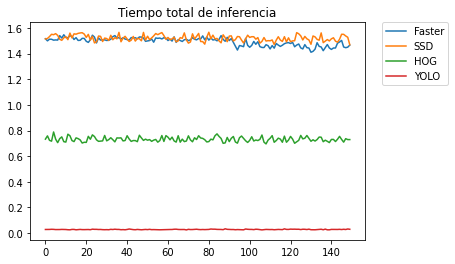

In [ ]:
%matplotlib inline
times_df = pd.DataFrame.from_records(times)
plt.plot(times_df)
plt.title("Tiempo total de inferencia")
plt.legend(list(times_df.columns.values), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Precisión

In [ ]:
infer_df = pd.DataFrame.from_records(inferencias)

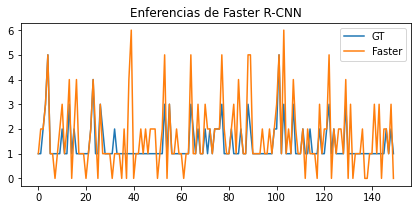

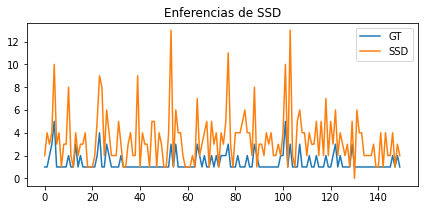

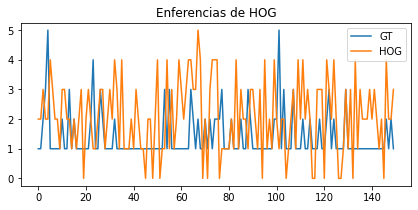

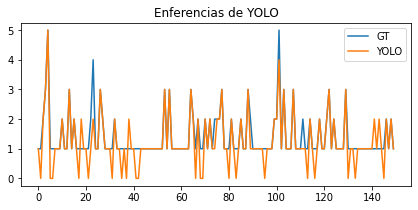

In [ ]:
infer_df[['GT', 'Faster']].plot(figsize=(7,3), title="Enferencias de Faster R-CNN")
infer_df[['GT', 'SSD']].plot(figsize=(7,3), title="Enferencias de SSD")
infer_df[['GT', 'HOG']].plot(figsize=(7,3), title="Enferencias de HOG")
infer_df[['GT', 'YOLO']].plot(figsize=(7,3), title="Enferencias de YOLO")

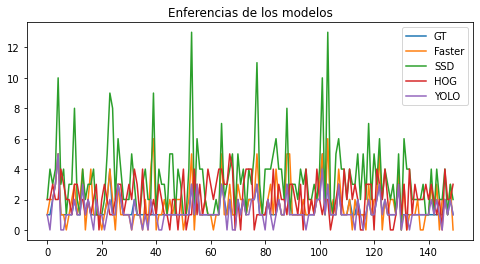

In [ ]:
infer_df.plot(figsize=(8,4), title="Enferencias de los modelos")

### Errores

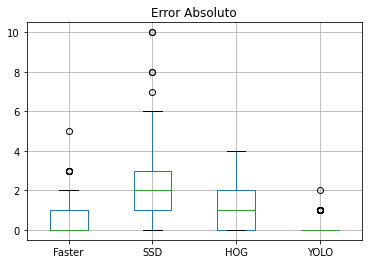

In [ ]:
abs_error = pd.DataFrame.from_records(inferencias)
abs_error['Faster'] = np.abs(abs_error["Faster"] - abs_error["GT"])
abs_error['SSD'] = np.abs(abs_error["SSD"] - abs_error["GT"])
abs_error['HOG'] = np.abs(abs_error["HOG"] - abs_error["GT"])
abs_error['YOLO'] = np.abs(abs_error["YOLO"] - abs_error["GT"])


plt.title("Error Absoluto")
abs_error[['Faster', 'SSD', 'HOG', 'YOLO']].boxplot()

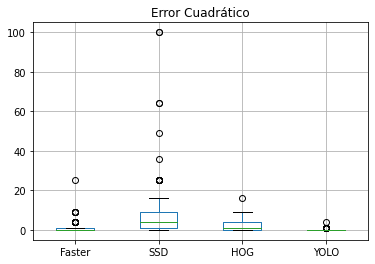

In [ ]:
sqr_error = pd.DataFrame.from_records(inferencias)
sqr_error['Faster'] = (sqr_error["Faster"] - sqr_error["GT"])**2
sqr_error['SSD'] = (sqr_error["SSD"] - sqr_error["GT"])**2
sqr_error['HOG'] = (sqr_error["HOG"] - sqr_error["GT"])**2
sqr_error['YOLO'] = (sqr_error["YOLO"] - sqr_error["GT"])**2


plt.title("Error Cuadrático")
sqr_error[['Faster', 'SSD', 'HOG', 'YOLO']].boxplot()

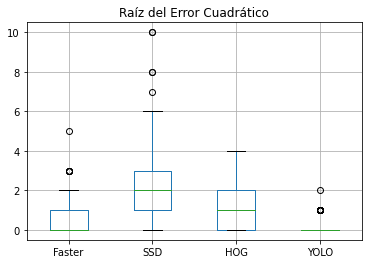

In [ ]:
root_sqr_error = pd.DataFrame.from_records(inferencias)
root_sqr_error['Faster'] = np.sqrt((root_sqr_error["Faster"] - root_sqr_error["GT"])**2)
root_sqr_error['SSD'] = np.sqrt((root_sqr_error["SSD"] - root_sqr_error["GT"])**2)
root_sqr_error['HOG'] = np.sqrt((root_sqr_error["HOG"] - root_sqr_error["GT"])**2)
root_sqr_error['YOLO'] = np.sqrt((root_sqr_error["YOLO"] - root_sqr_error["GT"])**2)


plt.title("Raíz del Error Cuadrático")
root_sqr_error[['Faster', 'SSD', 'HOG', 'YOLO']].boxplot()